In [1]:
import pandas as pd

# Load customer data
customers = pd.read_csv('Customers.csv')

# Load transaction data
transactions = pd.read_csv('Transactions.csv')

# Display the first few rows of each dataset
print(customers.head())
print(transactions.head())

  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067   2024-04-25 7:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price  
0      300.68  300.68  
1      300.68  300.68  
2      300.68  300.68  
3      601.36  300.68  
4      902.04  300.68  


In [2]:
# Convert SignupDate to datetime and extract useful features
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
customers['SignupYear'] = customers['SignupDate'].dt.year
customers['SignupMonth'] = customers['SignupDate'].dt.month

# One-hot encode the 'Region' column
customers_encoded = pd.get_dummies(customers[['Region']], drop_first=True)
customers = pd.concat([customers, customers_encoded], axis=1)

# Aggregate transaction data by CustomerID
transaction_features = transactions.groupby('CustomerID').agg(
    total_spend=pd.NamedAgg(column='TotalValue', aggfunc='sum'),
    total_quantity=pd.NamedAgg(column='Quantity', aggfunc='sum'),
    transaction_count=pd.NamedAgg(column='TransactionID', aggfunc='count'),
    avg_price=pd.NamedAgg(column='Price', aggfunc='mean')
).reset_index()

# Merge customer and transaction data
customer_data = pd.merge(customers, transaction_features, on='CustomerID', how='left')

# Check the merged data
print(customer_data.head())

  CustomerID        CustomerName         Region SignupDate  SignupYear  \
0      C0001    Lawrence Carroll  South America 2022-07-10        2022   
1      C0002      Elizabeth Lutz           Asia 2022-02-13        2022   
2      C0003      Michael Rivera  South America 2024-03-07        2024   
3      C0004  Kathleen Rodriguez  South America 2022-10-09        2022   
4      C0005         Laura Weber           Asia 2022-08-15        2022   

   SignupMonth  Region_Europe  Region_North America  Region_South America  \
0            7          False                 False                  True   
1            2          False                 False                 False   
2            3          False                 False                  True   
3           10          False                 False                  True   
4            8          False                 False                 False   

   total_spend  total_quantity  transaction_count   avg_price  
0      3354.52            12

In [3]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Impute missing values using mean strategy
imputer = SimpleImputer(strategy='mean')
customer_data_imputed = imputer.fit_transform(customer_data[['total_spend', 'total_quantity', 'transaction_count', 'avg_price']])

# Scale the data
scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(customer_data_imputed)


In [4]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# Function to calculate DB Index for different number of clusters
def calculate_db_index(X_scaled, max_clusters=10):
    db_indices = []
    for n_clusters in range(2, max_clusters+1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(X_scaled)
        db_index = davies_bouldin_score(X_scaled, kmeans.labels_)
        db_indices.append((n_clusters, db_index))
    return db_indices

# Calculate DB Index for clusters from 2 to 10
db_indices = calculate_db_index(customer_data_scaled, max_clusters=10)

# Print DB Index for different number of clusters
print("DB Index for each cluster count:")
for n_clusters, db_index in db_indices:
    print(f"Clusters: {n_clusters}, DB Index: {db_index}")


DB Index for each cluster count:
Clusters: 2, DB Index: 0.9608302965620468
Clusters: 3, DB Index: 1.0862565483657611
Clusters: 4, DB Index: 0.975073647866089
Clusters: 5, DB Index: 1.0198501643022797
Clusters: 6, DB Index: 1.0541663983484706
Clusters: 7, DB Index: 1.0022670278958583
Clusters: 8, DB Index: 0.9777328325605021
Clusters: 9, DB Index: 0.9970336113164
Clusters: 10, DB Index: 0.9333480734716358


In [5]:
# Choose the optimal number of clusters (e.g., 4)
optimal_clusters = 4

# Perform KMeans clustering with the chosen number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(customer_data_scaled)

# Add the cluster labels to the data
customer_data['Cluster'] = kmeans.labels_

# Check the cluster distribution
print(customer_data['Cluster'].value_counts())


Cluster
3    74
2    51
1    38
0    37
Name: count, dtype: int64


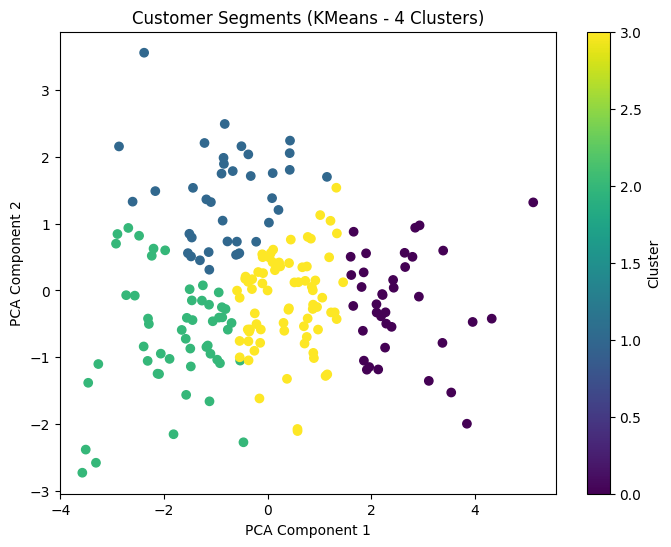

In [6]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Apply PCA to reduce data to 2 dimensions for visualization
pca = PCA(n_components=2)
customer_data_pca = pca.fit_transform(customer_data_scaled)

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(customer_data_pca[:, 0], customer_data_pca[:, 1], c=customer_data['Cluster'], cmap='viridis')
plt.title(f'Customer Segments (KMeans - {optimal_clusters} Clusters)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()
